In [1]:
pip install matplotlib keras

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
import time

In [3]:
# file is downloaded from finance.yahoo.com, 1.1.1997-1.1.2017
# training data = 1.1.1997 - 1.1.2007
# test data = 1.1.2007 - 1.1.2017
input_file="TSLA.csv"

In [4]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# fix random seed for reproducibility
np.random.seed(5)

In [5]:
# load the dataset
df = read_csv(input_file, delimiter=',')

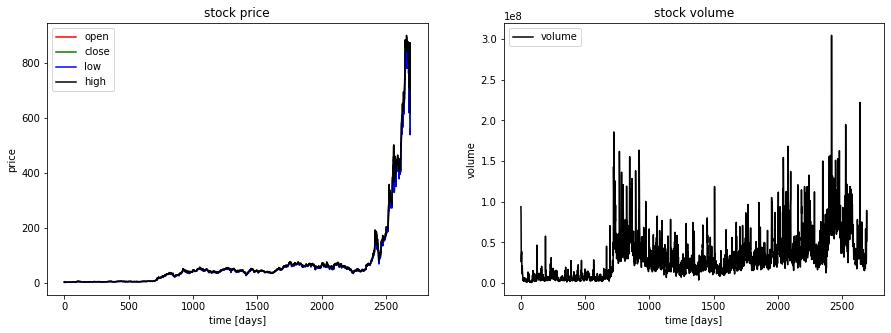

In [6]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df.Open.values, color='red', label='open')
plt.plot(df.Close.values, color='green', label='close')
plt.plot(df.Low.values, color='blue', label='low')
plt.plot(df.High.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df.Volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [7]:
# take close price column[5]
df = df.dropna(how='any',axis=0) 

all_y = df.Close.values


dataset=all_y.reshape(-1, 1)

print(any(math.isnan(x) for x in dataset))

False


In [8]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [9]:
# split into train and test sets, 50% test data, 50% training data
train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1, timestep 240
look_back = 240
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [10]:
print(len(trainX))
print(len(trainY))
print(len(testX))
print(len(testY))
print("-->")
print(len(train))
print(len(test))

1104
1104
1105
1105
-->
1345
1346


In [11]:
# create and fit the LSTM network, optimizer=adam, 25 neurons, dropout 0.1
model = Sequential()
model.add(LSTM(30, input_shape=(1, look_back)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=240, verbose=0)

# # reshape input to be [samples, time steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# model = Sequential()
# model.add(LSTM(25, input_shape=(trainX.shape[1], trainX.shape[2])))
# model.add(Dense(1))
# model.compile(loss='mean_absolute_error', optimizer='adam')
# model.fit(trainX, trainY, epochs=1000, batch_size=200, verbose=0)

# # reshape input to be [samples, time steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

[2021-03-09 23:14:36.084 tensorflow-2-3-gpu--ml-g4dn-xlarge-c85184389676cdfa7bdf06745c9b:548 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-03-09 23:14:36.109 tensorflow-2-3-gpu--ml-g4dn-xlarge-c85184389676cdfa7bdf06745c9b:548 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


In [12]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [13]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.09 RMSE
Test Score: 108.31 RMSE


testPrices:
testPredictions:
[[ 40.202595]
 [ 40.258858]
 [ 39.536053]
 ...
 [288.74533 ]
 [275.77856 ]
 [261.4878  ]]


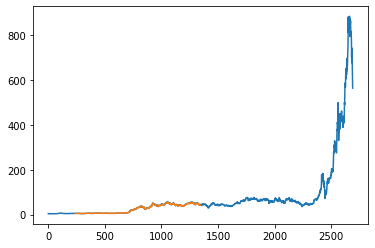

In [14]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
print('testPrices:')
testPrices=scaler.inverse_transform(dataset[test_size+look_back:])

print('testPredictions:')
print(testPredict)

In [15]:
print(len(dataset))
print(test_size + look_back)
print(len(dataset) - test_size - look_back)
print(len(testPredict))
print(len(testPrices))

2691
1586
1105
1105
1105


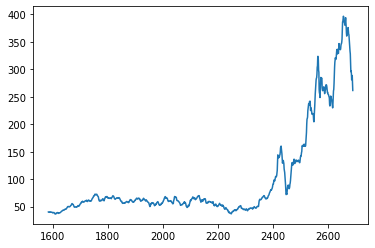

In [16]:
# export prediction and actual prices
df = pd.DataFrame(data={"prediction": np.around(list(testPredict.reshape(-1)), decimals=2), "test_price": np.around(list(testPrices.reshape(-1)), decimals=2)})
df.to_csv("lstm_result.csv",mode='w+' , sep=',', index=None)

# plot the actual price, prediction in test data=red line, actual price=blue line
plt.plot(testPredictPlot)
plt.show()

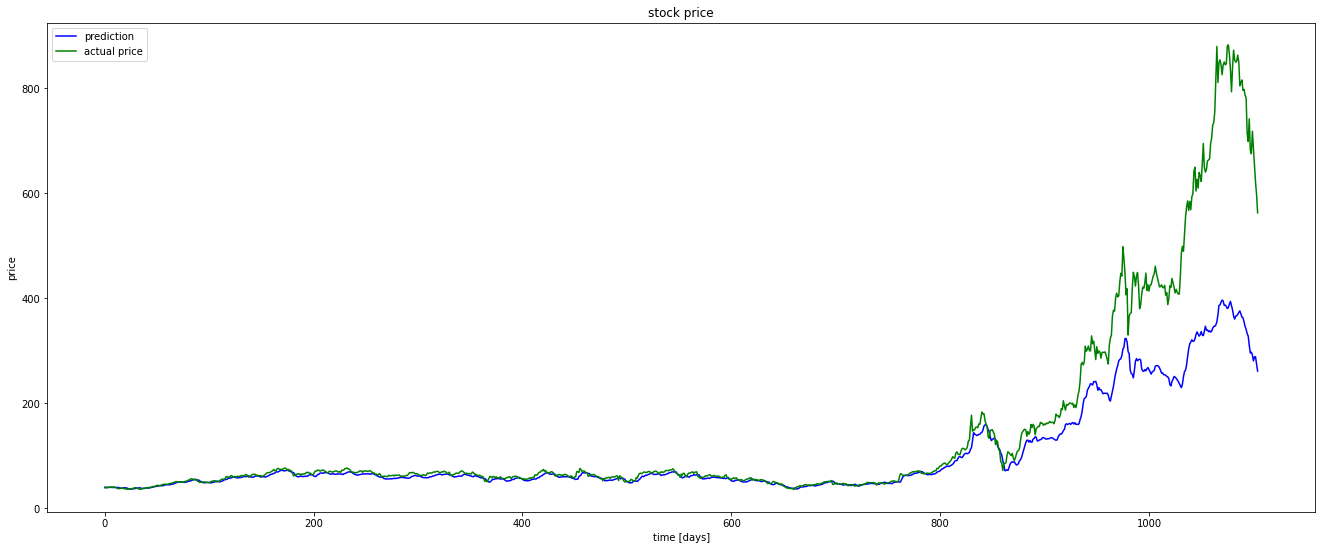

In [17]:
plt.figure(figsize = (50,9));
plt.subplot(1,2,1);
plt.plot(df.prediction.values, color='blue', label='prediction')
plt.plot(df.test_price.values, color='green', label='actual price')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
plt.show()